# Regression Module Recap

- [Overall Presentation Feedback](#Overall-Presentation-Feedback)
- [Pipeline Review](#Pipeline-Review)
- [Tips and Tricks](#Tips-and-Tricks)
- [Going Further](#Going-Further)

## Overall Presentation Feedback


- Talk through your visuals more: what is this? what are we looking at? why is this in the presentation? what is the takeaway? Remember your audience has never seen this viz before, even though you have probably been staring at it tweaking it for hours
- reiterate where the data comes from, size, prep, etc (doesn't have to be long) (e.g. our database contains... I used ...)
- communicate model performance is on unseen data
- executive summary -- overall good -- quantify model performance, drivers
- show don't tell, if a viz can explain it, it's generally preferable -- e.g. model performance comparison
- include answers to questions
- don't use animation; competes w/ attention; doesn't add anything; looks funky over zoom screen share (or in-person via an adapter!)

---

- Number Formatting: in tables, slides, visualizations
- use a diverging color palette for heatmaps, set anchors

## Pipeline Review

What happens when?

- SQL: acquire + prep
- drop outliers: prep
- Python: all over the place
- **imputation**: filling in missing values (w/ e.g. 0, or the average value): prep
- Pandas: all over the place
- train test split: prep -- before explore
- scaling: prep/modeling -- have a prep function that returns scaled and unscaled data
- hypothesis testing: explore
- visualization: all over the pipeline
- touching the test data: *only* at the end
    - scaling + imputation parameters are calculated from the **training** split
    - any data prep parameters are calculated from the training split
        - drop outliers -- any data point > 3 stds from the mean
        - mean + std are calculated from train, not test, not the whole dataset
    - before being fed into a model, test data is prepped in the same way the training data was
    - as far as prep goes -- if you could do it to a single new data point, you can do it to the test split

### MVP Pipeline Example

1. **Acquire**: acquire from SQL
1. **Prepare**: drop nulls; train_test_split
1. **Explore**: visualize each feature against the target
1. **Model**: calculate a baseline; fit a linear regression model on 2 features; fit a 2nd degree polynomial model; compare performance

### Iterate

1. Move functions to `wrangle.py`
1. Visualize multiple feature interactions
1. Stats tests
1. scale data and see how model performance is impacted
1. Impute nulls
1. Drop outliers
1. more model types
1. Cleanup visualizations
1. Tweak model hyperparameters
1. More visualizations

## Tips and Tricks

### Formatting numbers in pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [10]:
x = pd.Series(np.random.randn(5))
x

0    1.2153
1    0.6939
2   -0.5575
3    1.1917
4   -0.2369
dtype: float64

In [12]:
pd.options.display.float_format = '{:.2f}'.format
x

0    1.22
1    0.69
2   -0.56
3    1.19
4   -0.24
dtype: float64

In [13]:
pd.reset_option('display.float_format')
x

0    1.215304
1    0.693904
2   -0.557508
3    1.191721
4   -0.236900
dtype: float64

### Correlation Heatmaps

In [14]:
# some fake data for demonstration
np.random.seed(123)
df = pd.DataFrame()
df['x1'] = np.random.randn(100)
df['x2'] = np.random.randn(100) * 1_000_000
df['x3'] = df.x1 + np.random.randn(100)
df['x4'] = - df.x1 + np.random.randn(100)
df['x5'] = np.random.randn(100) * 100_000

<AxesSubplot:>

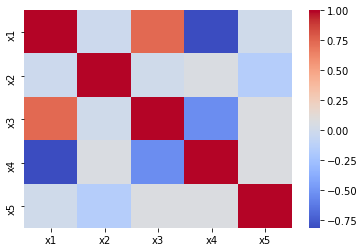

In [16]:
# Try also coolwarm, coolwarm_r
# see https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging
# vmin, vmax, center
sns.heatmap(df.corr(), cmap='coolwarm')

<AxesSubplot:>

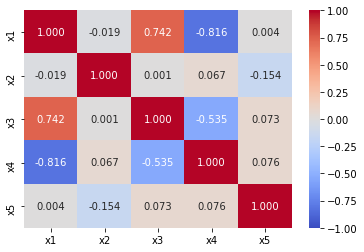

In [19]:
sns.heatmap(df.corr(), cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=True, fmt='.3f')

### Formatting Axis Ticks

<AxesSubplot:ylabel='Frequency'>

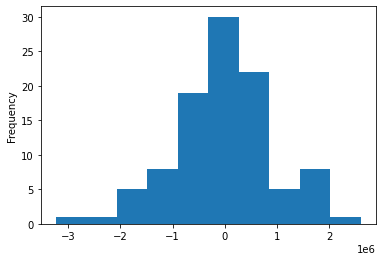

In [20]:
df.x2.plot.hist()

[Text(0.5, 0, 'x2 (millions)')]

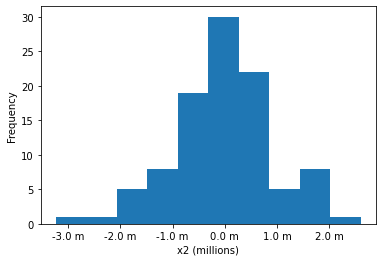

In [21]:
ax = df.x2.plot.hist()
ax.xaxis.set_major_formatter(lambda x, pos: '{:.1f} m'.format(x / 1_000_000))
ax.set(xlabel='x2 (millions)')

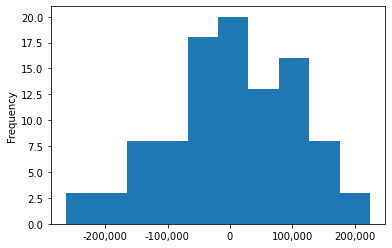

In [22]:
ax = df.x5.plot.hist()
ax.xaxis.set_major_formatter('{:,.0f}'.format)

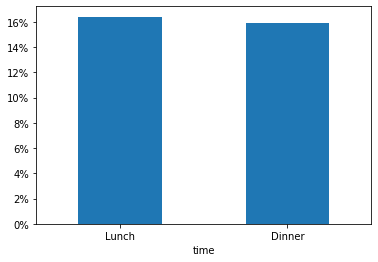

In [23]:
tips = sns.load_dataset('tips')
tips['tip_percentage'] = tips.tip / tips.total_bill

ax = tips.groupby('time').tip_percentage.mean().plot.bar()
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter('{:.0%}'.format)

### pandas table styling

In [35]:
df.corr().style.background_gradient(vmin=-1, vmax=1)

,x1,x2,x3,x4,x5
x1,1.000000,-0.019298,0.741611,-0.815776,0.003991
x2,-0.019298,1.000000,0.000956,0.067426,-0.154304
x3,0.741611,0.000956,1.000000,-0.534509,0.072687
x4,-0.815776,0.067426,-0.534509,1.000000,0.076014
x5,0.003991,-0.154304,0.072687,0.076014,1.000000


In [36]:
df.corr().style.background_gradient(vmin=-1, vmax=1, cmap='coolwarm_r').format('{:.3f}'.format)

,x1,x2,x3,x4,x5
x1,1.000,-0.019,0.742,-0.816,0.004
x2,-0.019,1.000,0.001,0.067,-0.154
x3,0.742,0.001,1.000,-0.535,0.073
x4,-0.816,0.067,-0.535,1.000,0.076
x5,0.004,-0.154,0.073,0.076,1.000


In [37]:
df.sample(5, random_state=123).style.highlight_max(axis=0)

,x1,x2,x3,x4,x5
8,1.265936,426146.639690,1.170734,-0.923298,3594.050250
70,0.468439,-1048991.677318,-0.744946,-2.719974,67364.893381
82,1.660952,1395352.929757,0.142845,-2.966738,-263143.803681
28,-0.140069,474347.297872,-1.377422,-0.052546,-58661.595085
63,-1.326265,704474.074044,-1.909802,2.002229,-59873.176668


In [38]:
df.sample(5, random_state=123).style.format({
    'x2': lambda x: '{:.3} million'.format(x / 1_000_000),
    'x3': '{:.1%}'.format,
    'x5': '{:,.1f}'.format,
})

,x1,x2,x3,x4,x5
8,1.265936,0.426 million,117.1%,-0.923298,"3,594.1"
70,0.468439,-1.05 million,-74.5%,-2.719974,"67,364.9"
82,1.660952,1.4 million,14.3%,-2.966738,"-263,143.8"
28,-0.140069,0.474 million,-137.7%,-0.052546,"-58,661.6"
63,-1.326265,0.704 million,-191.0%,2.002229,"-59,873.2"


### Further Reading

- [Matplotlib axis tick formatting](https://matplotlib.org/stable/gallery/ticks_and_spines/tick-formatters.html)
- [Matplotlib color pallettes](https://matplotlib.org/stable/tutorials/colors/colormaps.html#diverging)
- [Python string formatting docs](https://docs.python.org/3/library/string.html#formatstrings)
- [Pandas table styling](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html)

## Going Further

- Consider [median absolute error][1] as an evaluation metric. Large outliers, like in the zillow dataset, have a pretty big impact on RMSE.

    $ \mbox{MAE} = \mbox{med}(|y - \hat{y}|) $
    
- Interpret linear regression model coefficients to determine which features the model thinks are most important and specifically how they impact the target.

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html

In [39]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error as mae

tips = sns.load_dataset('tips')
X, y = tips[['total_bill', 'size']], tips.tip
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

lm = LinearRegression().fit(X_train, y_train)
print('Median Absolute Error: ${:.3f}'.format(mae(y_test, lm.predict(X_test))))
print()

for feature, coef in pd.Series(lm.coef_, index=X_train.columns).iteritems():
    print(f'---\nHolding other features constant,\nfor every 1 unit increase in {feature}\nthe model predicts tip amount goes up by ${coef:.3f}')

Median Absolute Error: $0.323

---
Holding other features constant,
for every 1 unit increase in total_bill
the model predicts tip amount goes up by $0.099
---
Holding other features constant,
for every 1 unit increase in size
the model predicts tip amount goes up by $0.221
